# Abrindo a caixa preta dos algoritmos de ML


### Motivação

Vimos que existem algoritmos de alta interpretabilidade como regressões lineares e arvores de decisão simples. Mas nem sempre (quase nunca) esses algoritmos simples são os que retornam os melhores resultados preditivos (os menores valores na nossa curva de custo). E ficamos nesse impasse, usar algoritmos simples para conseguir explicar como ele chegou nos resultados (e ter mais confiança da área não técnica) ou usar algoritmos super poderosos que não temos a minima ideia de como ele chegou em um resultado qualquer?


Uma saída para isso é usar as duas abordagens. Usa-se um algoritmo simples para sabermos o que está acontecendo e um mais poderoso que é uma caixa-preta para fazer previsões.


Outra saída é tentarmos abrir a caixa preta e entender o que se passa lá.

Vamos usar um dataset com caracteristicas de vinhos para treinarmos esses conceitos.


#### O problema
O presente problema se refere aos dados de vinhos portugueses "Vinho Verde", que possuem
variantes de vinho branco e tinto. Devido a questões de privacidade, apenas variáveis
físico-químicas (input) e sensoriais (output) estão disponíveis (por exemplo, não há dados
sobre tipo de uva, marca do vinho, preço de venda, etc).

Sabemos fazer as modelagens estatisticas, para entender quanto cada variável impacta na qualidade de vinhos, entendendo como são suas correlações parciais. Além disso, podemos entender como as variáveis endógenas influenciam umas as outras, e como essas interações influenciam a qualidade do vinho.

<img src='https://christophm.github.io/interpretable-ml-book/images/big-picture.png'>


Mas como ter esses mesmos insights em modelos de machine learning "black-box" como ensambles, redes neurais e outros? Na aula de hoje vamos construir a intuição e dar algumas possibilidades.


Usar **modelos lineares** resolve o problema da interpretabilidade. Mas temos pelo 4 grandes problemas.
1) Modelos lineares esperam outputs gaussianos. Solução: Usar modelos generalizados (GLM);

<img src='./img/1-nao-gaussiano.png'> 

2) Modelos lineares não "entendem" a interação entre as variáveis. Solução: Passar as interações explicitamente;

<img src='./img/2-interacao.png'> 

<img src='https://christophm.github.io/interpretable-ml-book/images/interaction-plot-1.png'>

3) Modelos lineares não entendem comportamentos não lineares. Solução: Modelagem estatistica;

<img src='./img/3-nao-linear.png'>
<img src='https://christophm.github.io/interpretable-ml-book/images/nonlinear-effects-1.png'>

4) Modelos lineares são dificieis de modelar para chegar no mesmo nivel de um não linear. Solução: Estudar e praticar bastante.

<img src='https://canaldoensino.com.br/blog/wp-content/uploads/2015/03/descansar-estudo.jpg'>

#### Objetivo e Dados
Criar um modelo para estimar a qualidade do vinho e entender como esses parâmetros explicam a qualidade do vinho
Informação sobre os atributos
Variáveis input (baseado em testes físico-químicos):
1. Tipo
2. Acidez fixa
3. Volatilidade da acidez
4. Ácido cítrico
5. Açúcar residual
6. Cloretos
7. Dióxido de enxofre livre
8. Dióxido de enxofre total
9. Densidade
10. pH
11. Sulfatos
12. Álcool

#### Variável output/target (baseado em dado sensorial):
Qualidade (score entre 0 and 10)


#### Bibliografia
- https://christophm.github.io/interpretable-ml-book/
- Shapley, Lloyd S. “A value for n-person games.” Contributions to the Theory of Games 2.28 (1953): 307-317.


Wikipedia: "... Desde o trabalho de John von Neumann e Oskar Morgenstern na década de 1940, Lloyd Shapley tem sido considerado a própria personificação da teoria dos jogos. Juntamente com Alvin Roth, foi laureado com o Prémio de Ciências Económicas em Memória de Alfred Nobel de 2012. ..."

In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from io import StringIO
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
from sklearn.model_selection import train_test_split

wine=pd.read_csv("winequality.csv",sep=';')
wine.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,White,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [ ]:
wine.describe()

In [ ]:
wine[wine.alcohol==97.333000]['alcohol']=9.7333000

In [ ]:
wine['type'].value_counts()

In [ ]:
wine.shape

In [ ]:
wine.drop_duplicates().shape

In [ ]:
wine.isnull().sum()

In [ ]:
red_counts=wine.groupby('quality').size()
plt.xlabel("Qualidade")
plt.ylabel("Quantidade")
plt.title('Histograma Distribuição das notas')
red_counts.plot(kind='bar', color='b')
plt.show()

In [9]:
print("white mean = ", wine[wine['type']=='Red']["quality"].mean())         
print("red mean =", wine[wine['type']=='White']["quality"].mean())

white mean =  5.6360225140712945
red mean = 5.87790935075541


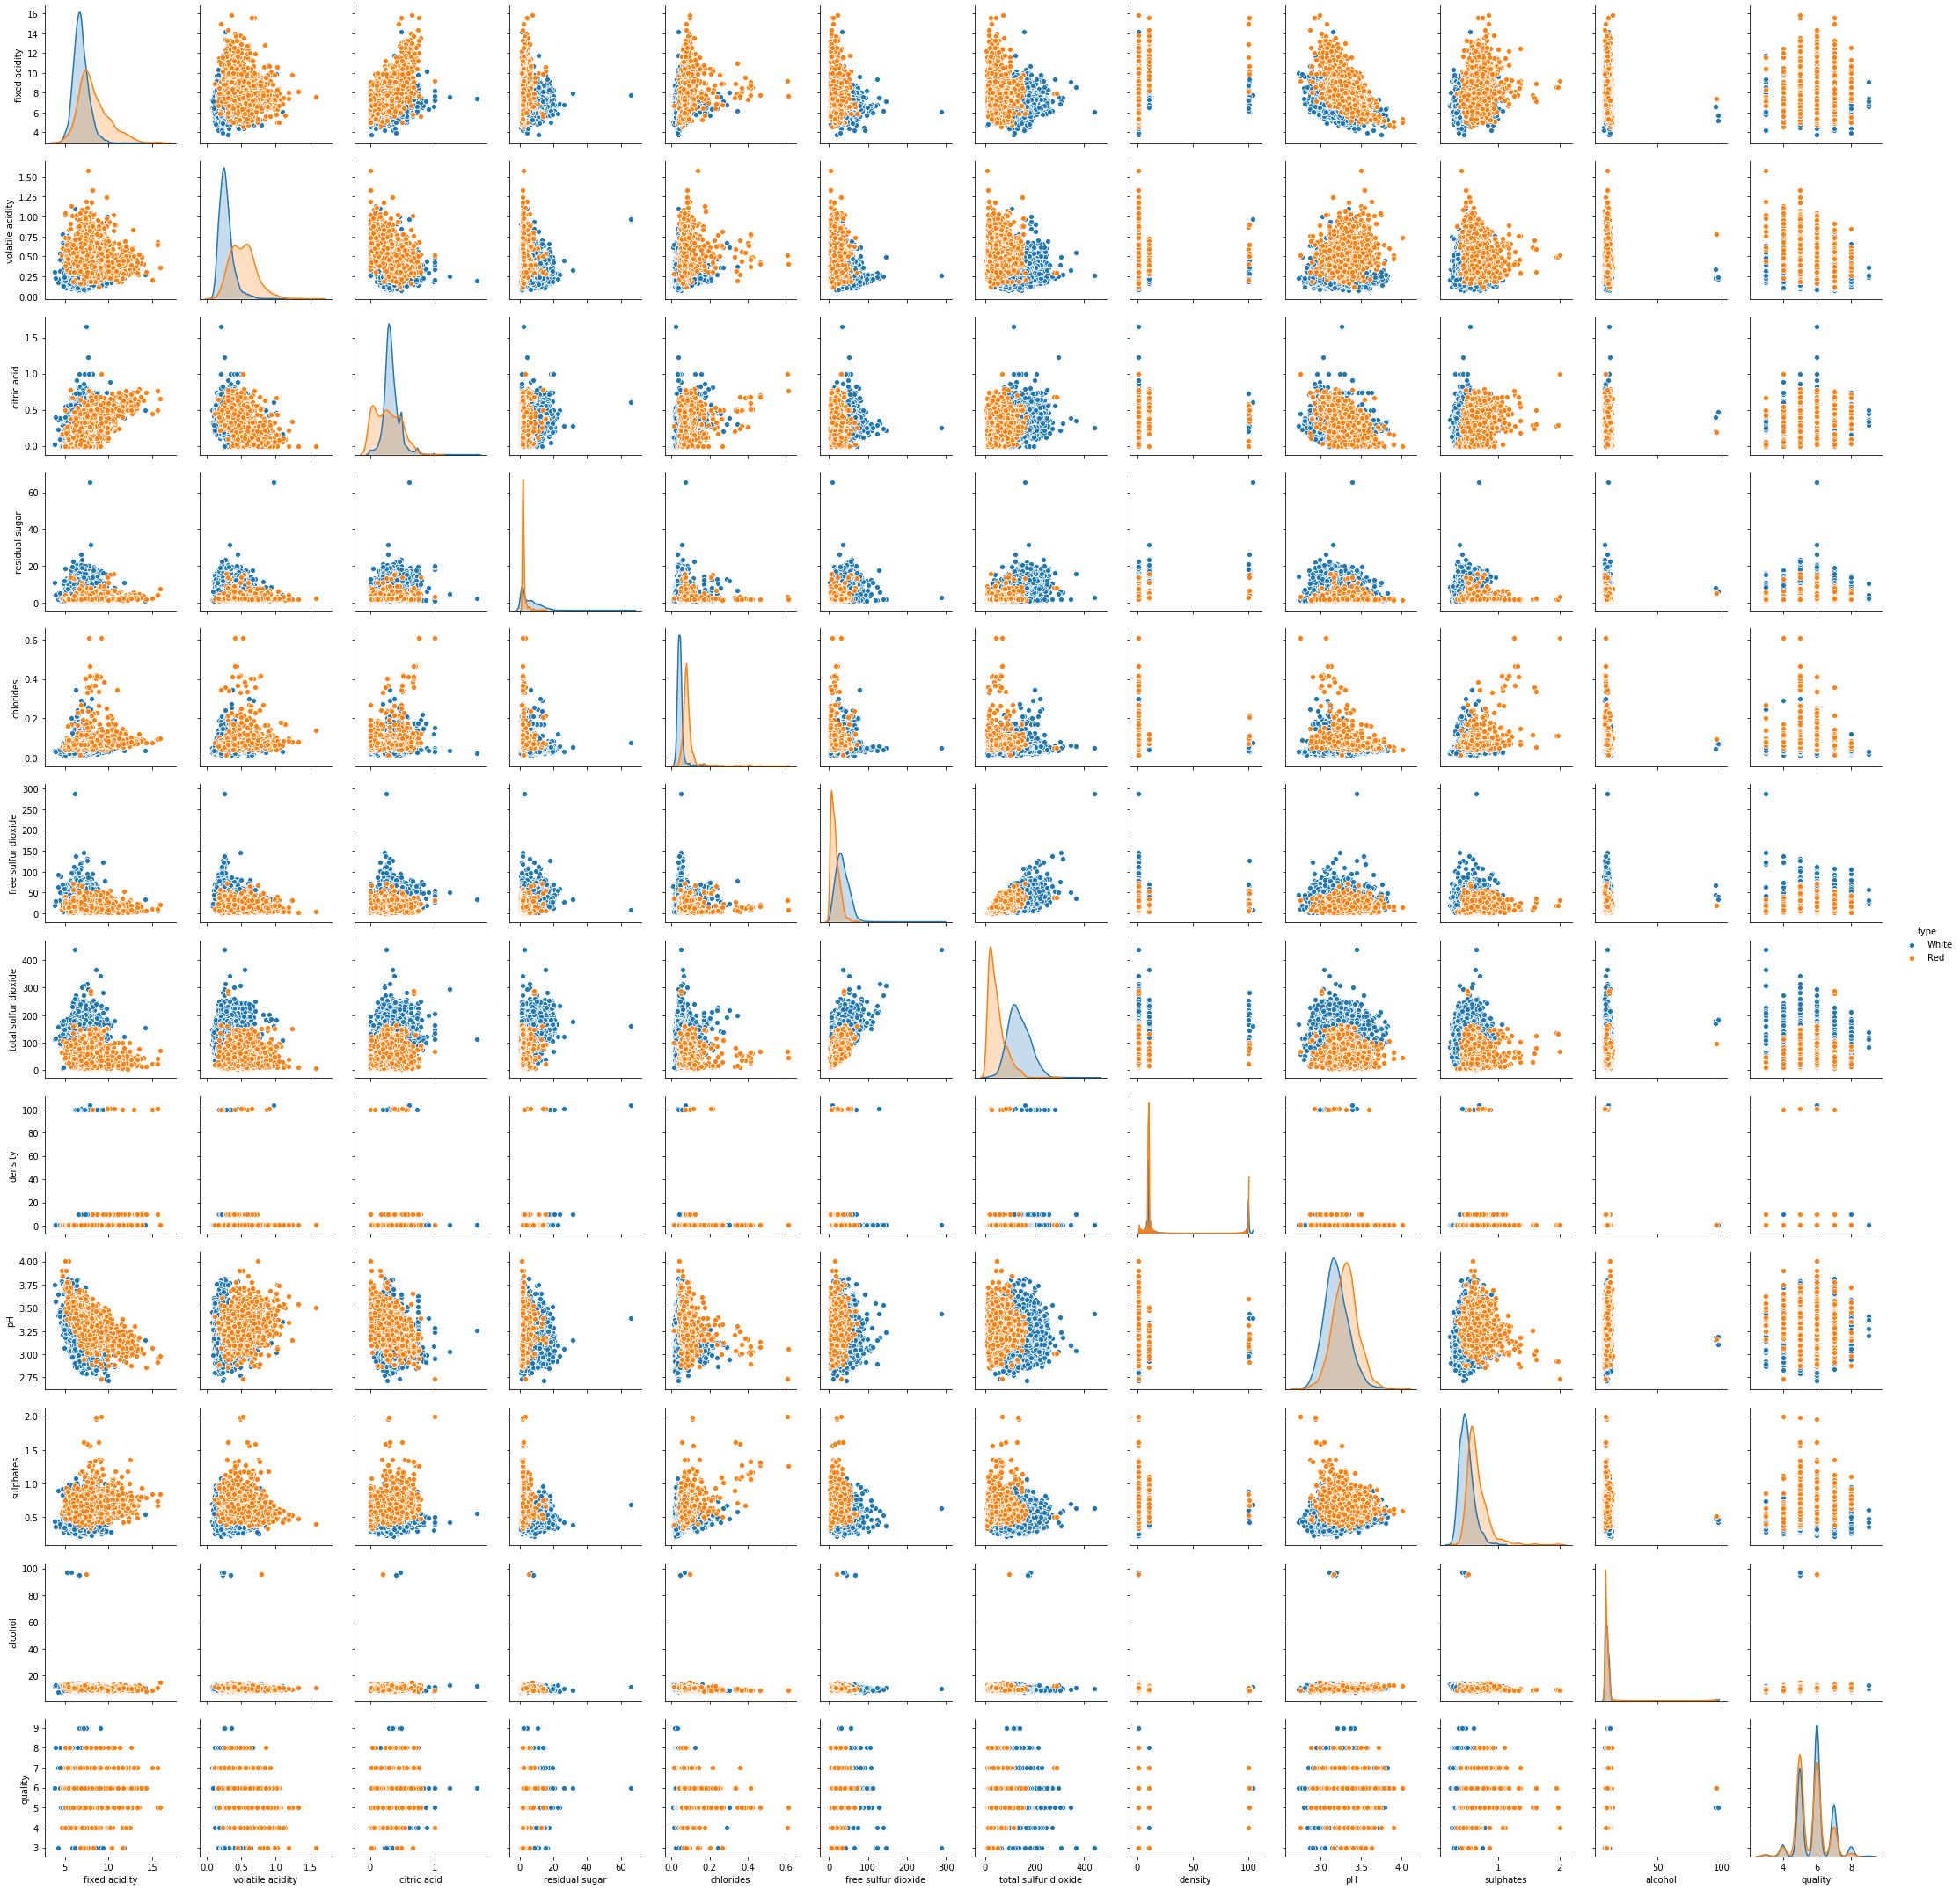

In [10]:
sns.pairplot(wine.drop_duplicates(), hue='type')

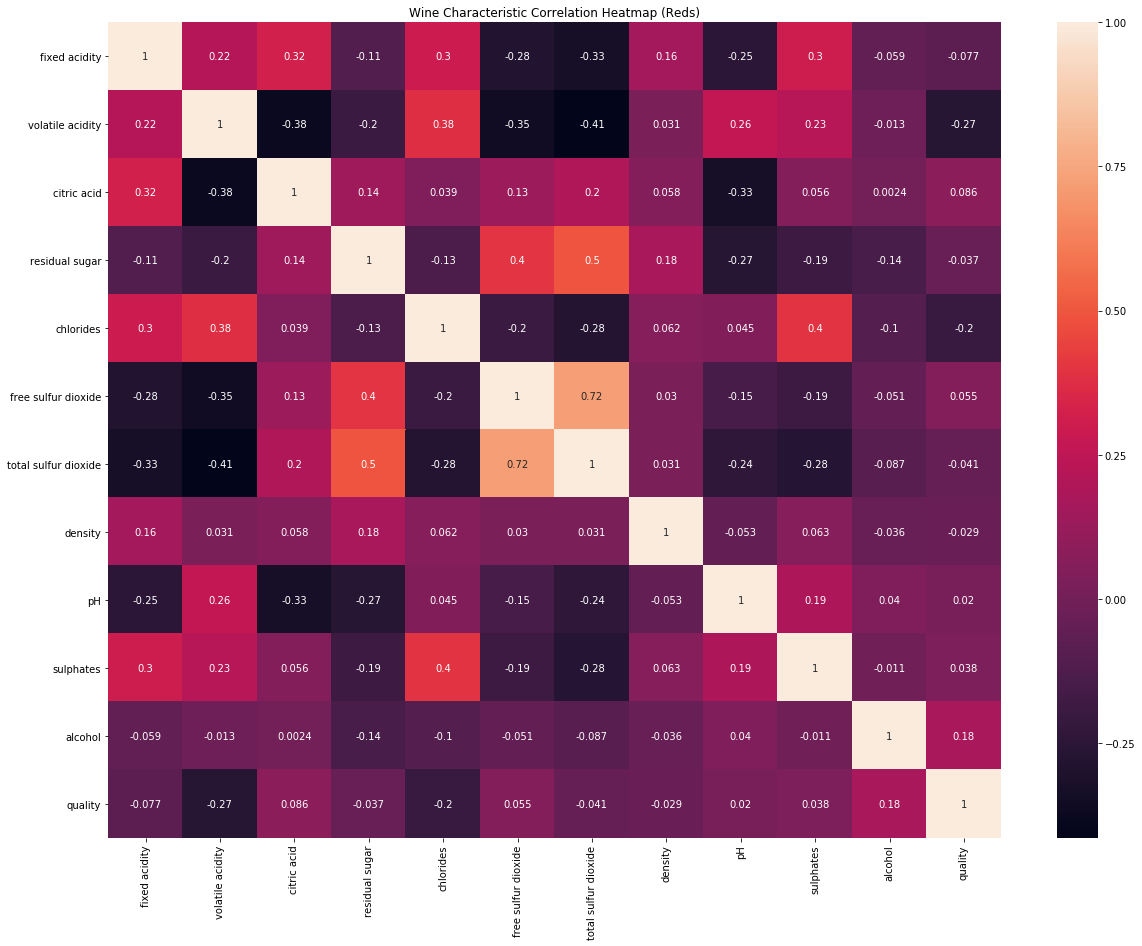

In [11]:
plt.subplots(figsize=(20,15))
ax = plt.axes()
ax.set_title("Wine Characteristic Correlation Heatmap (Reds)")
corr = wine.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           annot=True)
plt.show()

In [12]:
wine.rename(columns={'fixed acidity': 'fixed_acidity','citric acid':'citric_acid','volatile acidity':'volatile_acidity','residual sugar':'residual_sugar','free sulfur dioxide':'free_sulfur_dioxide','total sulfur dioxide':'total_sulfur_dioxide'}, inplace=True)

In [13]:
wine.dtypes

type                     object
fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [14]:
function1 = '''
quality ~ total_sulfur_dioxide
+ free_sulfur_dioxide 
+ residual_sugar 
+ fixed_acidity 
+ volatile_acidity 
+ alcohol 
+ citric_acid 
+ sulphates
+ chlorides
+ pH 
+ density
+ C(type)
'''

results1 = smf.ols(function1, data=wine).fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     105.7
Date:                Fri, 24 May 2019   Prob (F-statistic):          9.05e-241
Time:                        08:28:36   Log-Likelihood:                -7757.3
No. Observations:                6497   AIC:                         1.554e+04
Df Residuals:                    6484   BIC:                         1.563e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                5.2973 

In [15]:
from sklearn.model_selection import train_test_split

wine_w_dummies = pd.get_dummies(wine)

X = wine_w_dummies.drop('quality', axis=1)
y = wine_w_dummies['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [16]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
from sklearn.model_selection import train_test_split


dtr = DecisionTreeRegressor(max_depth=4)
dtr.fit(X_train,y_train)
yhat = dtr.predict(X_test)
r2 = metrics.r2_score(y_test,yhat)
mse = metrics.mean_squared_error(y_test,yhat)

print(f'r2: {round(r2,4)}, mse:{round(mse,4)}')

r2: 0.2591, mse:0.5438


In [17]:
dot_data = StringIO()
export_graphviz(dtr,
                out_file=dot_data,  
                filled=True,
                rounded=True,
                special_characters=True,
                feature_names=list(X))
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

ModuleNotFoundError: No module named 'pydotplus'

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(max_depth=4, n_estimators=1000)
gbr.fit(X_train,y_train)
yhat = gbr.predict(X_test)
r2 = metrics.r2_score(y_test,yhat)
mse = metrics.mean_squared_error(y_test, yhat)

print(f'r2: {round(r2,4)}, mse:{round(mse,4)}')

In [ ]:
test_score = np.zeros((1000,), dtype=np.float64)

for i, y_pred in enumerate(gbr.staged_predict(X_test)):
    test_score[i] = gbr.loss_(y_test, y_pred)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Custo Treino x Teste')
plt.plot(np.arange(1000) + 1, gbr.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(1000) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Custo')

In [ ]:
feature_importance = gbr.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Bonus - Usando Teoria dos Jogos


## SHAP Values

https://github.com/slundberg/shap

Você viu (e usou) técnicas para extrair insights gerais de um modelo de aprendizado de máquina. Mas e se você quiser detalhar como o modelo funciona para uma previsão individual?

Os valores SHAP (um acrônimo da SHApley Additive exPlanations) dividem uma previsão para mostrar o impacto de cada recurso. Onde você poderia usar isso?


- Um modelo diz que um banco não deve emprestar dinheiro a alguém, e o banco é legalmente obrigado a explicar a base para cada rejeição de empréstimo. 

- Um profissional de saúde deseja identificar quais fatores estão direcionando o risco de alguma doença de cada paciente, para que possam abordar diretamente esses fatores de risco com intervenções de saúde direcionadas.

In [ ]:
import shap

In [ ]:
shap_values = shap.TreeExplainer(gbr).shap_values(X_test)

### Plot importance com shap values

In [ ]:
global_shap_vals = np.abs(shap_values).mean(0)[:-1]
variables_values = pd.DataFrame(list(zip(X_test.columns,global_shap_vals)))
variables_values.rename(columns={0:'variable',1:'shap_value'},inplace=True)
variables_values.sort_values(by=['shap_value'],ascending=False,inplace=True)
top_n = variables_values.head(25)

pos=range(0,-top_n.shape[0],-1)
plt.barh(pos, top_n['shap_value'], color="#1E88E5")
plt.yticks(pos, top_n['variable'])
plt.xlabel("mean SHAP value magnitude (change in log odds)")
plt.gcf().set_size_inches(8, 5.5)
plt.gca()
plt.show()

### Resumo dos impactos das variáveis no modelo

In [ ]:
shap.summary_plot(shap_values, X_test)

### Vamos entender agora como o Modelo afeta uma única predição

In [ ]:
row_to_show = 5
data_for_prediction = X_test.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

# Create object that can calculate shap values
explainer = shap.TreeExplainer(gbr)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

O objeto shap_values acima é uma lista com duas matrizes. A primeira matriz na lista é os valores de SHAP para um resultado negativo (não ganhe o prêmio). A segunda matriz é a lista de valores SHAP para o resultado positivo, que é como normalmente pensamos em previsões. É complicado revisar uma matriz bruta, mas o pacote shap tem uma boa maneira de visualizar os resultados. 

In [ ]:
# Interpretação: Valores em vermelho aumentam o rating médio e os valores azuis diminuem.
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

E se fizessemos o grafico acima para diversas observações? poderiamos entender por exemplo como o impacto das variáveis "evolui"?

No grafico abaixo fizemos 100 graficos semelhantes ao de cima e viramos 90 graus

In [ ]:
# visualize the training set predictions
shap_values = shap.TreeExplainer(gbr).shap_values(X_test.head(100))
shap.force_plot(explainer.expected_value, shap_values, X_test.head(100))

In [ ]:
shap_values = shap.TreeExplainer(gbr).shap_values(X_test)
shap.dependence_plot("sulphates", shap_values, X_test)

In [ ]:
shap_values = shap.TreeExplainer(gbr).shap_values(X_test)
shap.dependence_plot("volatile_acidity", shap_values, X_test)

### Para aprender como funciona por dentro utilize o paper original: https://arxiv.org/abs/1705.07874


### Para ter uma interpretação mais intuitiva, há diversos textos pela internet, como esse: https://medium.com/@gabrieltseng/interpreting-complex-models-with-shap-values-1c187db6ec83

